<a href="https://colab.research.google.com/github/Kryptera-K/AVGO-Elder-Bear-Power-Klinger-Volume-Reversal-Strategy/blob/main/AVGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AVGO"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AVGO_clean.csv", index=False)
df

/tmp/ipython-input-1047848233.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2009-08-06,1.139775,1.191198,1.096100,1.162317,241978000
2009-08-07,1.157385,1.180631,1.129208,1.137661,24543000
2009-08-10,1.124982,1.171474,1.099622,1.171474,24210000
2009-08-11,1.103848,1.127095,1.091873,1.125686,23054000
2009-08-12,1.127094,1.141183,1.103143,1.137661,14513000
...,...,...,...,...,...
2025-12-23,349.320007,350.109985,338.540009,340.809998,28232600
2025-12-24,350.220001,352.859985,347.140015,350.690002,11424400
2025-12-26,352.130005,353.250000,347.750000,351.059998,15028100


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13

# -------------------------
# Indicator Functions
# -------------------------

def bears_power_lower_than(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return df['Bears_Power'] < level


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df


def kvo_cross_above_level(df, level=KVO_LEVEL):
    df = klinger_volume_oscillator(df)
    kvo = df['KVO']
    return (kvo > level) & (kvo.shift(1) <= level)


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["BearP_Lower_0"] = bears_power_lower_than(df)

# -------------------------
# Exit conditions
# -------------------------

df["KVO_Cross_Above_Zero"] = kvo_cross_above_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'BearP_Lower_0',
]
exit_conditions = [
    'KVO_Cross_Above_Zero',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2009-08-06 00:00:00
End                                  2025-12-30 00:00:00
Period                                4126 days 00:00:00
Start Value                                     100000.0
End Value                                44322034.632892
Total Return [%]                            44222.034633
Benchmark Return [%]                        30005.394287
Max Gross Exposure [%]                             100.0
Total Fees Paid                            674808.268406
Max Drawdown [%]                               49.276837
Max Drawdown Duration                  348 days 00:00:00
Total Trades                                          52
Total Closed Trades                                   51
Total Open Trades                                      1
Open Trade PnL                           -3948552.716943
Win Rate [%]                                   82.352941
Best Trade [%]                                 96.183743
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2009-08-06 00:00:00
End                           2025-12-30 00:00:00
Period                         4126 days 00:00:00
Start Value                              100000.0
End Value                         30105394.286775
Total Return [%]                     30005.394287
Benchmark Return [%]                 30005.394287
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        49.276837
Max Drawdown Duration           348 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    30005394.286775
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-76669221.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


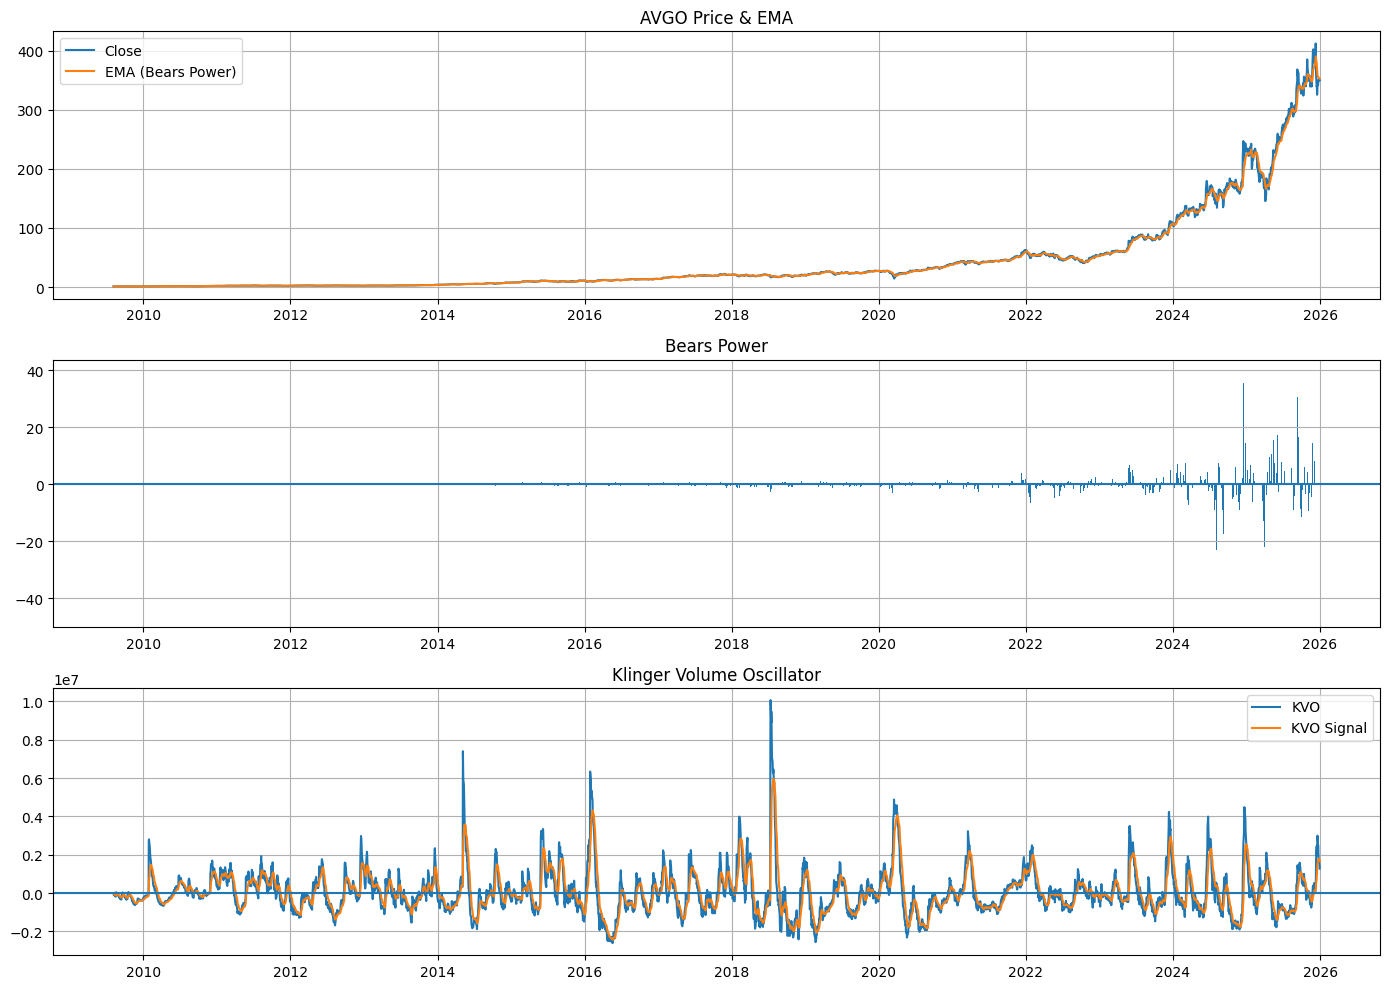

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "AVGO"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, interval="1d",multi_level_index=False)
df = df.dropna()

# -------------------------
# Parameters
# -------------------------
BEAR_EMA_PERIOD = 13
KVO_SHORT = 34
KVO_LONG = 55
KVO_SIGNAL = 13

# -------------------------
# Bears Power
# -------------------------
df["EMA"] = df["Close"].ewm(span=BEAR_EMA_PERIOD, adjust=False).mean()
df["Bears_Power"] = df["Low"] - df["EMA"]

# -------------------------
# Klinger Volume Oscillator
# -------------------------
dm = df["High"] - df["Low"]
cm = np.cumsum(np.where(df["Close"] > df["Close"].shift(1), dm, -dm))

vf = df["Volume"] * abs(
    2 * (df["Close"] - df["Low"]) / (df["High"] - df["Low"]) - 1
)

df["KVO"] = vf.ewm(span=KVO_SHORT).mean() - vf.ewm(span=KVO_LONG).mean()
df["KVO_Signal"] = df["KVO"].ewm(span=KVO_SIGNAL).mean()

plt.figure(figsize=(14, 10))

# -------------------------
# Price + EMA
# -------------------------
plt.subplot(3, 1, 1)
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df.index, df["EMA"], label="EMA (Bears Power)")
plt.title(f"{symbol} Price & EMA")
plt.legend()
plt.grid(True)

# -------------------------
# Bears Power
# -------------------------
plt.subplot(3, 1, 2)
plt.bar(df.index, df["Bears_Power"])
plt.axhline(0)
plt.title("Bears Power")
plt.grid(True)

# -------------------------
# Klinger Volume Oscillator
# -------------------------
plt.subplot(3, 1, 3)
plt.plot(df.index, df["KVO"], label="KVO")
plt.plot(df.index, df["KVO_Signal"], label="KVO Signal")
plt.axhline(0)
plt.title("Klinger Volume Oscillator")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
